In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

import pytorch_lightning as pl

In [2]:
batch_size = 8
NUM_WORKERS = int(os.cpu_count() / 2)


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=NUM_WORKERS)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=NUM_WORKERS)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
NUM_CLASSES = len(classes)

Files already downloaded and verified
Files already downloaded and verified


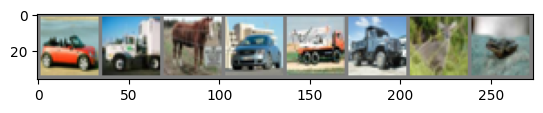

car   truck horse car   truck truck deer  frog 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torchvision
from torch import nn
import torch.nn.functional as F
from torchmetrics import Accuracy

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
class LitResnet(pl.LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = Net()
        self.train_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss)
        acc = self.train_accuracy(logits, y)
        self.log("train_accuracy", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log("val_loss", loss)
        acc = self.val_accuracy(logits, y)
        self.log("val_accuracy", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.lr, momentum=0.9)
        return optimizer

In [8]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import RichProgressBar

In [ ]:
model = LitResnet(lr=0.001)

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[RichProgressBar()]
)

trainer.fit(model, train_dataloader, val_dataloader)

Epoch 2/29 ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 3020/6250 0:00:31 • 0:00:34 96.70it/s v_num: 2.000